## Introduction

We want to be able to indentify legendary pokemon based on type, stats, and generation, and other features. This will be a binary classification problem.

In [10]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [11]:
data = pd.read_csv('Pokemon.csv')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


There are some particular features that seem to be highly occur along with the positive class (being legendary): a low capture rate and inability to breed.  In another python notebook on this file, I've webscraped these two features and put them in a csv.

In [13]:
cpt_rates = pd.read_csv("pkmn_capture_rates.csv")

cpt_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   names               721 non-null    object
 1   capture_rate        721 non-null    object
 2   can_breed           721 non-null    int64 
 3   capture_rate_clean  721 non-null    int64 
 4   pkmn_number         721 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 28.3+ KB


In [14]:
# we join on the pokemon's assigned number
data = data.merge(cpt_rates, how='left', left_on='#', right_on ='pkmn_number')
# drop the columns from the cpt_rates csv that we won't need
data = data.drop(["names", "pkmn_number", "capture_rate"], axis = 1)

In [15]:
# lets standardize the column names
data.columns = [col.lower()
                   .replace(".","") 
                   .replace(" ", "_")
                for col in data.columns]

# how much of the data is legendaries?
data['legendary'].sum() / data.shape[0]

0.0925

## <u>Preprocessing</u>
### Stratified Sampling

Since the positive class is rare, let's use a stratified sampling method.

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=24)
for train_index, test_index in split.split(data, data['legendary']):
    train = data.loc[train_index]
    test = data.loc[test_index]

### Data Cleaning

In [17]:
# removing mega evolutions
train = train[train['name'].apply(lambda col: True if not re.search('\wMega',col) else False)] # "Mega" is typically after a word
test = test[test['name'].apply(lambda col: True if not re.search('\wMega',col) else False)] 

In [18]:
# remove unnecessary columns
train = train.drop(['#', 'name'], axis = 1)
test = test.drop(['#', 'name'], axis = 1)

In [19]:
# make the generation into an object type instead of a number
train['generation'] = train['generation'].astype(str)
test['generation'] = test['generation'].astype(str)

In [20]:
# we remove the total feature since by definition is colinear with other stats
train = train.drop('total', axis = 1)
test = test.drop('total', axis = 1)

### Exploration

Since mega-evolutions are gone, let's do some exploratory analysis.

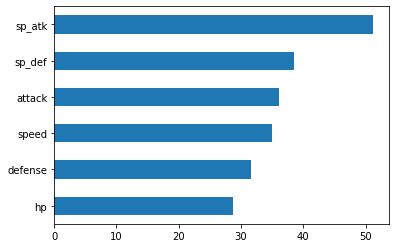

In [21]:
train.pivot_table(index='legendary', values=['hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed'], aggfunc=np.mean) \
     .apply(lambda row: row[True] - row[False], axis=0) \
     .sort_values() \
     .plot.barh()

We see that on average, most legendary pokemon have much higher sp_atk that regular pokemon.

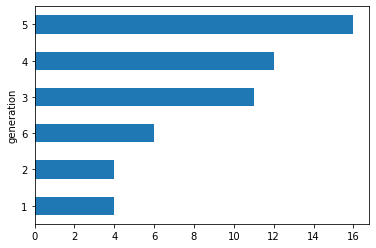

In [22]:
train.pivot_table(index='generation', values=['legendary'], aggfunc=np.sum)\
     .sort_values(by='legendary')\
     .plot.barh(legend=False)

Some generations do have more legendaries than others.

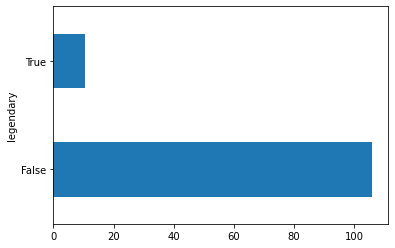

In [23]:
train.pivot_table(index='legendary', values=['capture_rate_clean'], aggfunc=np.mean)\
     .plot.barh(legend=False)

Most legendaries have a *much* lower capture rate.

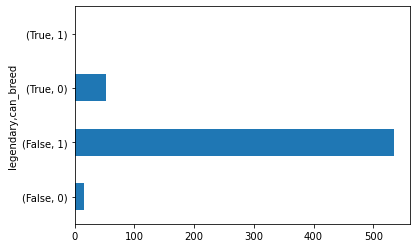

In [24]:
train.pivot_table(index=['legendary','can_breed'], values=['capture_rate_clean'], aggfunc=np.size)\
     .plot.barh(legend=False)

Most legendaries can't breed and most non-legendaries can breed.

### Column Transformation
#### Type Indicator
We want to make sure that the model doesn't care if a type is type_1 or type_2 if it's the same type. For example, we don't want a type_1_water dummy columns AND a type_2_water dummy column. We'd rather have a water_ind dummy column that has 1 when either type_1 and type_2 are Water. This will also reduce 
34 potential dummy columns for type to 17.

In [25]:
# get all the unique types
types = set(np.concatenate((train['type_1'].unique(), 
                            train['type_2'].dropna().unique()))) # get all the types in the train and test
types = list(types)

# make a column for each type on the train and test set
for type_ in types:
    dummy_col = type_.lower() + "_ind"
    train[dummy_col] = train.apply(lambda row: 1 if row['type_1'] == type_ or row['type_2'] == type_ else 0, axis = 1)

for type_ in types:
    dummy_col = type_.lower() + "_ind"
    test[dummy_col] = test.apply(lambda row: 1 if row['type_1'] == type_ or row['type_2'] == type_ else 0, axis = 1)
    
# drop the old column
train = train.drop(['type_1', 'type_2'], axis = 1)
test = test.drop(['type_1', 'type_2'], axis = 1)    

#### One-hot Encoding 

In [26]:
def create_dummies(df, column_name, drop = True):
    
    dummies = pd.get_dummies(df[column_name], prefix = column_name)
    df = pd.concat([df, dummies], axis = 1)
    if drop:
        df = df.drop(column_name, axis = 1)
    return df

In [27]:
train = create_dummies(train, "generation")
test = create_dummies(test, "generation")

Let's look at a heatmap to view colinearity and relation to the positive class.

In [28]:
def plot_correlation_heatmap(df):
    
    corr = df.corr()
    sns.set(style = 'white')
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (11, 9))
    cmap = sns.diverging_palette(10, 150, as_cmap = True)
    sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
                square= True, linewidth = .5, cbar_kws = {'shrink':.5})
    plt.show()

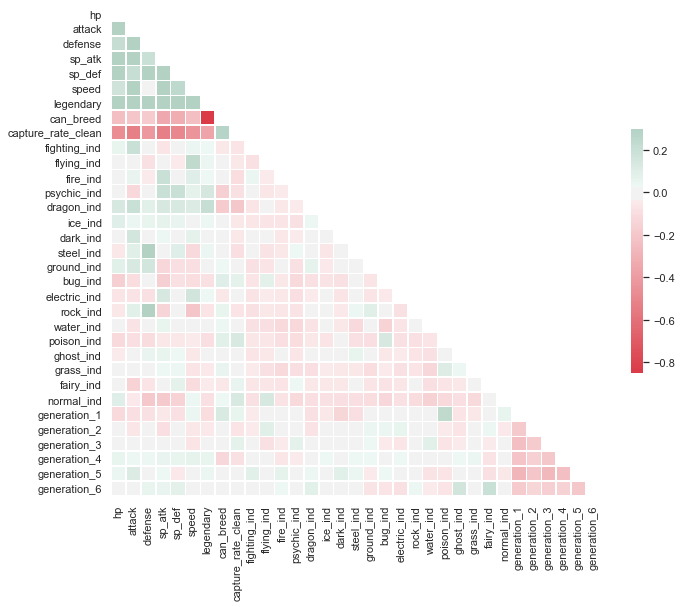

In [29]:
plot_correlation_heatmap(train)

**Insights:**

We see that generations are weak indicators of legendaries, and we saw that they're isn't many legendaries per generation to begin with.

Type isn't a good indicators of legendaries either.

Being dragon or psychic is a strong indicator that pokemon might be legendary.

We may be able to remove sp atk and defense since they're correlated with other types too.





In [33]:
# based on our insights, let's drop the generation features
train = train.drop(['generation_1', 'generation_2', 'generation_3', 'generation_4', 'generation_5', 'generation_6'], axis=1)
test = test.drop(['generation_1', 'generation_2', 'generation_3', 'generation_4', 'generation_5', 'generation_6'], axis=1)

# let's remove most of the type dummy features
train = train.drop(['fairy_ind', 'rock_ind', 'fighting_ind', 'electric_ind', 'bug_ind', 'normal_ind', 'grass_ind', 
                    'ghost_ind', 'water_ind', 'steel_ind','dark_ind', 'ice_ind', 'poison_ind', 'flying_ind', 
                    'ground_ind', 'fire_ind', 'psychic_ind', 'dragon_ind'], axis=1)

test = test.drop(['fairy_ind', 'rock_ind', 'fighting_ind', 'electric_ind', 'bug_ind', 'normal_ind', 'grass_ind', 
                    'ghost_ind', 'water_ind', 'steel_ind','dark_ind', 'ice_ind', 'poison_ind', 'flying_ind', 
                    'ground_ind', 'fire_ind', 'psychic_ind', 'dragon_ind'], axis=1)

train = train.drop(['hp', 'attack'], axis=1)

test = test.drop(['hp', 'attack'], axis=1)

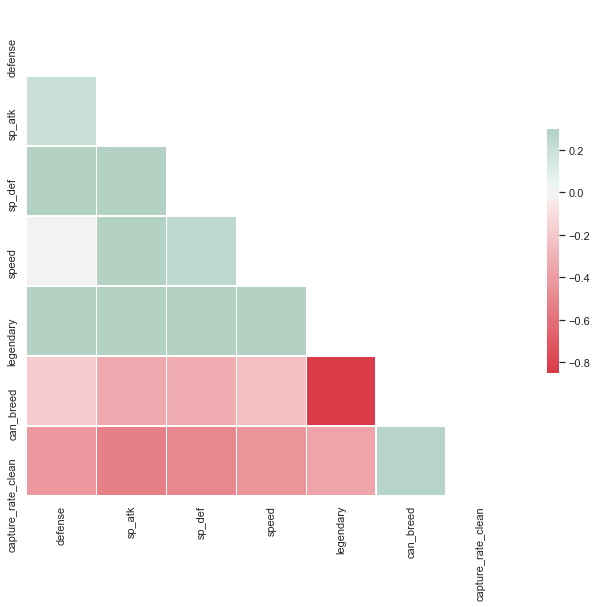

In [34]:
plot_correlation_heatmap(train)

In [35]:
# splitting the features and labels
X_train = train.drop('legendary', axis = 1)
X_test = test.drop('legendary', axis = 1)

y_train = train['legendary'] 
y_test = test['legendary'] 

## <u>Modeling
    
We'll use a logistic regression model for now.

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

Again, since the positive class is rare, using an accuracy score can be misleading (you'd get a high score if you'd just predict that NO pokemon are legendary), but let's see it:

In [45]:
lr.score(X_test, y_test) 

0.9932885906040269

### Decision Scores

Since we're working with a rare positive class need need to have good precision and recall for our model.
The logistic regression model has a decision_function that outputs the confidence it has that a pokemon is a legendary, so we will use that.

Let's also use cross validation with our model.

In [46]:
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(lr, X_train, y_train, cv = 3,
                             method = 'decision_function')

### Precision-Recall Curve

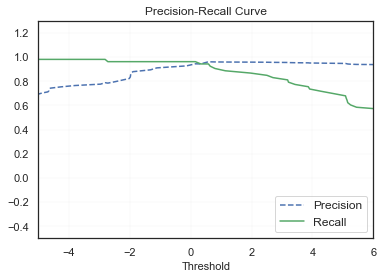

In [47]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="lower right", fontsize=12)
    plt.xlabel("Threshold", fontsize=11)        
    plt.grid(True, linewidth=.1)                             
    plt.axis([-5, 6, -.5, 1.3])
    plt.title("Precision-Recall Curve", loc="center")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [48]:
# We'd like to maximize recall, while having good
names = ["precision", "recall", "thresholds"]
prt_dict = {name:nums for name, nums in zip(names, [precisions[:-1], recalls[:-1], thresholds])}
prt_df = pd.DataFrame(prt_dict)
prt_df[prt_df["recall"].between(.92,.98)]  # this is the recall range we're interested in, based on the curve above.

,precision,recall,thresholds
64,0.784615,0.962264,-2.719776
65,0.796875,0.962264,-2.473624
66,0.822581,0.962264,-2.017445
67,0.836066,0.962264,-1.981768
68,0.864407,0.962264,-1.964976
69,0.879310,0.962264,-1.896145
70,0.894737,0.962264,-1.314822
71,0.910714,0.962264,-1.112062
72,0.927273,0.962264,-0.136130
73,0.944444,0.962264,0.156139


We decide that the threshold of -0.136130 is best since it'll keep the recall around around #####80%, while keeping the precision relatively high. 

In [52]:
new_threshold = -0.136129

#### Testing and Setting the new Threshold

In [53]:
from sklearn.metrics import precision_score, recall_score

new_pred = y_scores >= new_threshold

print(f'precision score: {precision_score(y_train, new_pred)}\n\
   recall score: {recall_score(y_train, new_pred)}')

precision score: 0.9444444444444444
   recall score: 0.9622641509433962


### Test Set

We'll finally how the model performs with data it hasn't seen.

In [55]:
test_preds = lr.decision_function(X_test) >=  new_threshold

print(f'precision score: {precision_score(y_test, test_preds)}\n\
   recall score: {recall_score(y_test, test_preds)}')

precision score: 1.0
   recall score: 0.9333333333333333


The model correctly labeled over 90% of legendary pokemon in the test set as a legendary.  
It did not label any regular pokemon as legendary.

Let's look at the coefficients of the model to see which features the model believes contribute most to being legendary.

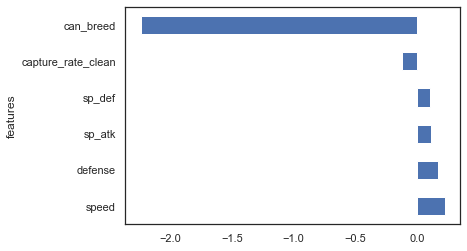

In [60]:
features = list(X_train.columns)
coefs = list(lr.coef_[0])

pd.DataFrame({'features':features,
              'coefs':coefs})\
  .sort_values(by=['coefs'], ascending=False)\
  .set_index("features")\
  .plot.barh(legend=False)

Since ability to breed is such a large indicator that a pokemon is legendary, let's see all the pokemon that can't breed and aren't legendary

In [85]:
data[(data['can_breed'] == 0) & ~(data['legendary'])]

,#,name,type_1,type_2,total,hp,attack,defense,sp_atk,sp_def,speed,generation,legendary,can_breed,capture_rate_clean
35,30,Nidorina,Poison,NaN,365,70,62,67,55,55,56,1,False,0,120
36,31,Nidoqueen,Poison,Ground,505,90,92,87,75,85,76,1,False,0,45
186,172,Pichu,Electric,NaN,205,20,40,15,35,35,60,2,False,0,190
187,173,Cleffa,Fairy,NaN,218,50,25,28,45,55,15,2,False,0,150
188,174,Igglybuff,Normal,Fairy,210,90,30,15,40,20,15,2,False,0,170
189,175,Togepi,Fairy,NaN,245,35,20,65,40,65,20,2,False,0,190
216,201,Unown,Psychic,NaN,336,48,72,48,72,48,48,2,False,0,225
255,236,Tyrogue,Fighting,NaN,210,35,35,35,35,35,35,2,False,0,75
257,238,Smoochum,Ice,Psychic,305,45,30,15,85,65,65,2,False,0,45
258,239,Elekid,Electric,NaN,360,45,63,37,65,55,95,2,False,0,45


Which pokemon did the model misclassify?

In [87]:
combined = pd.concat([X_train, X_test], axis =0)

combined['pred'] = lr.decision_function(combined) >= new_threshold
x = combined.merge(data, how='inner', left_index=True, right_index=True)\
        .sort_index()\
        .loc[:,['name', 'pred', 'legendary']]

x[x['pred'] != x['legendary']]

,name,pred,legendary
263,Entei,False,True
412,Metagross,True,False
698,Volcarona,True,False


In [89]:
# let's look at the above pokemon
data[data['name'].isin(['Entei', 'Metagross', 'Volcarona'])]

,#,name,type_1,type_2,total,hp,attack,defense,sp_atk,sp_def,speed,generation,legendary,can_breed,capture_rate_clean
263,244,Entei,Fire,NaN,580,115,115,85,90,75,100,2,True,0,3
412,376,Metagross,Steel,Psychic,600,80,135,130,95,90,70,3,False,1,3
698,637,Volcarona,Bug,Fire,550,85,60,65,135,105,100,5,False,1,15


We misclassify Metagross and Volcarona, likely because their high stats and very low capture make them look like legendary pokemon.

Entei is an interesting case since it may represent a chance for improvement in the model. It was still misclassified as a regular pokemon even though (1) it can't breed, (2) has the lowest capture rate possible, and (3) has high stats. 

### Conclusion

We achieved a precision/recall in the 90s for the test set. Based on the model, it seems a pokemon that's can't breed it's a large indicator that a pokemon is legendary. 

However, for regular pokemon that can't breed, the model that can use it's capture rate and it's stats, since these pokemon typically have combination of lower stats and higher capture rates.

## Next Time:

see if you can make any actions from the exploration phase especially the correlation map.

see if you can make so that we can see which features predict being legendary the best.

By using the correlation map, we achieve around r/p of 90/79 which is good.

Next let's make a function where you can type in any pokeon name and we can see what the classifier thinks it is.

Maybe we can try using grid search, RCEV to see which features are best to keep.

For git hub, I might just remove the experimentation piece. Else I can make a transformer or a combined dataframe to see which  (in a neat way) to see which pokemon the classfier erroneouly classifies.

## Experimenting

let's make a function that takes in a pokemon name and then runs the model and see if this is a pokemon or not!

In [79]:
def find_legend_status(input_name):
    
    input_name = input_name.lower().capitalize()
    input_index = data[data['name'] == input_name].index[0]
    try:
        score = lr.decision_function(X_train.loc[[input_index],:])
    except KeyError:
        score =  lr.decision_function(X_test.loc[[input_index],:])
    label = score >= new_threshold
    return score, label


In [90]:
find_legend_status("entei")

(array([-0.67656636]), array([False]))